# Supplemental Figures

# 1. Off-target analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import warnings
import os
import functools
import upsetplot

warnings.filterwarnings('ignore')
plt.rc('font', family='Helvetica')

In [2]:
OT_holder = []
for i in range(1,16):
    aa1 = pd.read_csv(f'MBESv2_OT_CasOFF/batch{i}.txt', sep='\t')
    print(i)
    mismatch_num = [0,1,2,3,4]

    guides = np.unique(aa1['crRNA'])

    num_g = len(guides)

    OT_df = pd.DataFrame(dict(zip(['gRNA_sequence', '0', '1', '2', '3', '4'], [guides, np.zeros(num_g), np.zeros(num_g), np.zeros(num_g), np.zeros(num_g), np.zeros(num_g)])))

    for mismatch in mismatch_num:
        subset = aa1[aa1['Mismatches']==mismatch]

        u, c = np.unique(subset['crRNA'], return_counts=True)
        ot_dict = dict(zip(u,c))

        for guide in u:
            OT_df.loc[OT_df['gRNA_sequence']==guide, f'{mismatch}']=ot_dict[guide]

    OT_holder.append(OT_df)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [3]:
OT_combined = pd.concat(OT_holder).reset_index(drop=True)


lib = pd.read_csv('MBESv2_CORRECTED.csv')

crRNA = [f'{i[1:]}NG' for i in lib['Protospacer']]
lib['gRNA_sequence'] = crRNA
l1 = lib[['gRNA_id', 'gRNA_sequence', 'classification', 'Pool', 'Editor']]

m1 = pd.merge(OT_combined, l1, on='gRNA_sequence')

CBE_OT = m1[(m1['Pool']=='F2-R2') & (m1['classification']=='targeting guide')]
ABE_OT = m1[(m1['Pool']=='F1-R1') & (m1['classification']=='targeting guide')]

In [4]:
bin_names = ['0','1-9','10-99','100+']
bins = [[0,0],[1,9],[10,99],[100,1e10]]

mismatch_num = [0,1,2,3,4]
count_holder = []
for mismatch in mismatch_num:

    u, c = np.unique(CBE_OT[f'{mismatch}'], return_counts=True)

    if mismatch==0:
        u = u-1
        #account for fact that 1 target when mismatch = 0 = true target

    df_ot = pd.DataFrame(dict(zip(['num_targets', 'count'], [u,c])))
    
    count = []
    for k in bins:
        low = k[0]
        high = k[1]

        subset = df_ot[(df_ot['num_targets']>=low) & (df_ot['num_targets']<=high)]
        count.append(sum(subset['count']))

    count_holder.append(count)

df_plot = pd.DataFrame(dict(zip(['No. Off-Targets', '0 Mismatches', '1 Mismatches', '2 Mismatches', '3 Mismatches', '4 Mismatches'], [bin_names] + count_holder)))


#------and then for ABE-------
count_holder = []
for mismatch in mismatch_num:

    u, c = np.unique(ABE_OT[f'{mismatch}'], return_counts=True)

    if mismatch==0:
        u = u-1
        #account for fact that 1 target when mismatch = 0 = true target

    df_ot = pd.DataFrame(dict(zip(['num_targets', 'count'], [u,c])))
    
    count = []
    for k in bins:
        low = k[0]
        high = k[1]

        subset = df_ot[(df_ot['num_targets']>=low) & (df_ot['num_targets']<=high)]
        count.append(sum(subset['count']))

    count_holder.append(count)

df_plot_ABE = pd.DataFrame(dict(zip(['No. Off-Targets', '0 Mismatches', '1 Mismatches', '2 Mismatches', '3 Mismatches', '4 Mismatches'], [bin_names] + count_holder)))

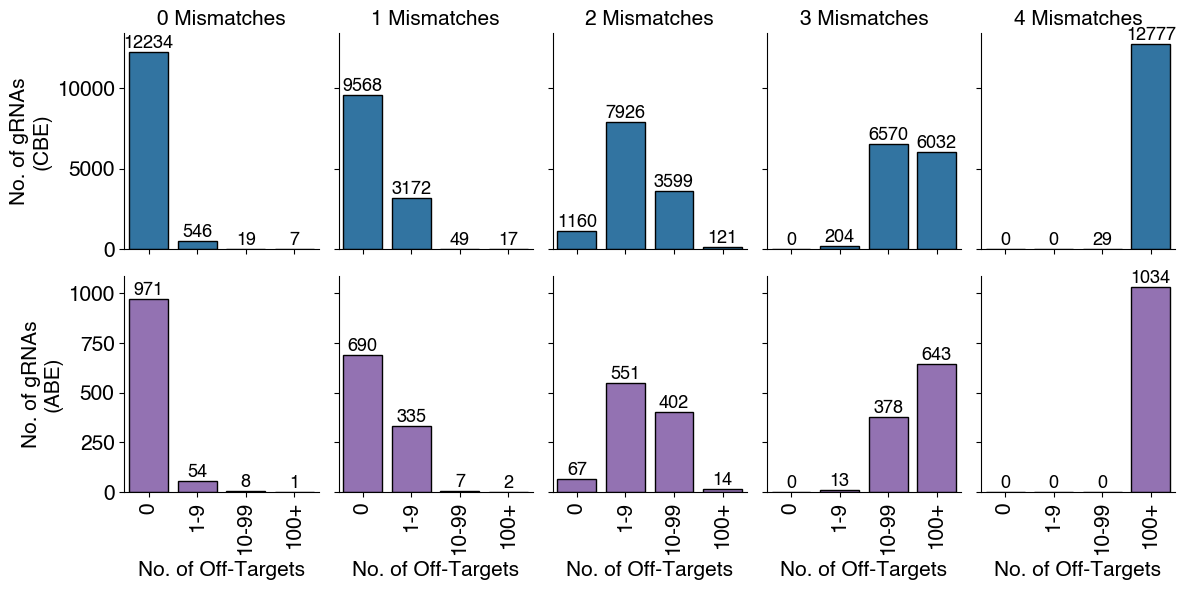

In [ ]:
fig, ax = plt.subplots(2,5, figsize=(12,6), sharex=True, sharey='row')

for i in range(5):
    sns.barplot(data=df_plot, x='No. Off-Targets', y=f'{i} Mismatches', ax=ax[0][i], color='tab:blue', edgecolor='black', linewidth=1)
    ax[0][i].spines[['right', 'top']].set_visible(False)
    ax[0][i].tick_params(axis='both', which='major', labelsize=15)
    #ax[0][i].set_xticklabels(ax[0][i].get_xticklabels(), rotation=90)
    ax[0][i].set_title(f'{i} Mismatches', fontsize=15)
    ax[0][i].set_xlabel('No. of Off-Targets', fontsize=15)
    ax[0][i].bar_label(ax[0][i].containers[0], fontsize=13)

for i in range(5):
    sns.barplot(data=df_plot_ABE, x='No. Off-Targets', y=f'{i} Mismatches', ax=ax[1][i], color='tab:purple', edgecolor='black', linewidth=1)
    ax[1][i].spines[['right', 'top']].set_visible(False)
    ax[1][i].tick_params(axis='both', which='major', labelsize=15)
    ax[1][i].set_xticklabels(ax[1][i].get_xticklabels(), rotation=90)
    #ax[1][i].set_title(f'{i} Mismatches', fontsize=15)
    ax[1][i].set_xlabel('No. of Off-Targets', fontsize=15)
    ax[1][i].bar_label(ax[1][i].containers[0], fontsize=13) # only 1 container needed unless using `hue`


ax[0][0].set_ylabel('No. of gRNAs\n(CBE)', fontsize=15)
ax[1][0].set_ylabel('No. of gRNAs\n(ABE)', fontsize=15)

fig.tight_layout()
#fig.savefig('figures/OT_analysis.pdf', transparent=True)

# 2. Pairwise replicate comparisons

To run plots for condition of interest, change COI parameter

Choices = ['d15', 'spleen', 'bonemarrow', 'meninges']

In [6]:
ABE_LFC = pd.read_csv('ABE_LFC_FDR_df.csv')
CBE_LFC = pd.read_csv('CBE_LFC_FDR_df.csv')

CBE_samp_dict2 = {'spleen':['spleen1','spleen2','spleen3','spleen4','spleen5','spleen6','spleen7','spleen8','spleen9'],
 'bonemarrow':['bonemarrow1','bonemarrow2','bonemarrow3','bonemarrow4','bonemarrow5','bonemarrow6','bonemarrow7','bonemarrow8','bonemarrow9','bonemarrow10'],
 'meninges':['meninges1','meninges2','meninges3','meninges4','meninges5','meninges6','meninges7','meninges8','meninges9','meninges10',],
 'd5':['d5_rep1','d5_rep2','d5_rep3'],
 'd15':['d15_rep1','d15_rep2','d15_rep3'],}

ABE_samp_dict2 = {'spleen':['spleen1','spleen2','spleen3','spleen4'],
 'bonemarrow':['bonemarrow1','bonemarrow2','bonemarrow3','bonemarrow4','bonemarrow5'],
 'meninges':['meninges1','meninges2','meninges3','meninges4','meninges5'],
 'd5':['d5_rep1','d5_rep2','d5_rep3'],
 'd15':['d15_rep1','d15_rep2','d15_rep3'],}


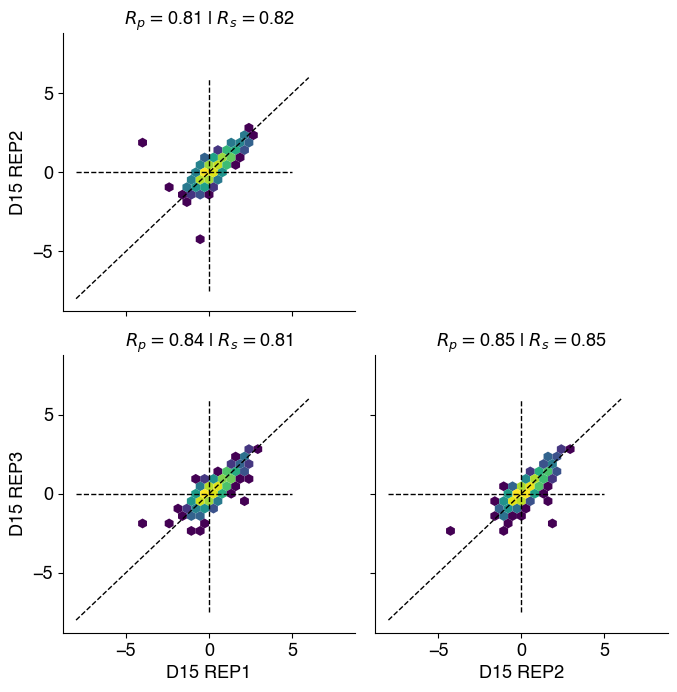

In [ ]:
COI = 'd15'
min_edit = 50
samples = list(ABE_samp_dict2[COI])

s2 = samples +  ['classification', 'target_base_edit_perc']
KO = ABE_LFC[s2]

KO = KO[KO['target_base_edit_perc']>= min_edit]

fig, ax = plt.subplots(len(samples),len(samples),figsize=(10,10), sharex=True, sharey=True)

palette = ['#F9CBA8', '#ED6A50', '#7284A1', 'lightgrey', 'darkslategray']


s_dict = {'LFC_d15': 'LFC In Vitro', 'LFC_spleen': 'LFC Spleen', 'LFC_bone': 'LFC Bone', 'LFC_meninges': 'LFC Meninges'}
for idx, samp in enumerate(samples):

    row = idx
    for idx2, samp2 in enumerate(samples):
        col = idx2
        ax[row][col].hexbin(KO[samp2], KO[samp], bins='log', gridsize=30, linewidth=0, extent = (-8, 8, -8, 8))

        ax[row][col].plot([0,0],[-7.5,6], linestyle='dashed', color='black', linewidth=1)
        ax[row][col].plot([-8,5],[0,0], linestyle='dashed', color='black', linewidth=1)
        ax[row][col].plot([-8,6],[-8,6], linestyle='dashed', color='black', linewidth=1)


        if samp[-2:]=='10':
            j1 = f'{samp[:-2].upper()} {samp[-2:]}'
        elif '_' in samp:
            j1 = samp.split('_')[0].upper() + ' ' + samp.split('_')[1].upper()
        else:
            j1 = f'{samp[:-1].upper()} {samp[-1:]}'

        if samp2[-2:]=='10':
            j2 = f'{samp2[:-2].upper()} {samp2[-2:]}'
        elif '_' in samp2:
            j2 = samp2.split('_')[0].upper() + ' ' + samp2.split('_')[1].upper()
        else:
            j2 = f'{samp2[:-1].upper()} {samp2[-1:]}'


        ax[row][0].set_ylabel(j1, fontsize=13)
        ax[len(samples)-1][col].set_xlabel(j2, fontsize=13)
    #ax[idx//3][idx%3].set_xticklabels(['S', 'B', 'M'])
    #ax[idx//3][idx%3].set_yticklabels(['IV', 'S', 'B',])
    #ax[idx//3][idx%3].set_title(f'{gene}', fontsize=12)

        ax[row][col].spines[['top', 'right']].set_visible(False)

        ax[row][col].tick_params(axis='both', which='major', labelsize=13,)

        spear = np.round(scipy.stats.spearmanr(KO[samp2], KO[samp]).statistic, 2)
        pear = np.round(scipy.stats.pearsonr(KO[samp2], KO[samp]).statistic, 2)

        ax[row][col].set_title('$R_{p} = $' + f'{pear}' + ' | $R_{s} = $' + f'{spear}', fontsize=13)


        if row<=col:
            fig.delaxes(ax[row][col])

fig.tight_layout()
#fig.savefig(f'figures/ABE_supp_pairwise_comp_{COI}.pdf', transparent=True)

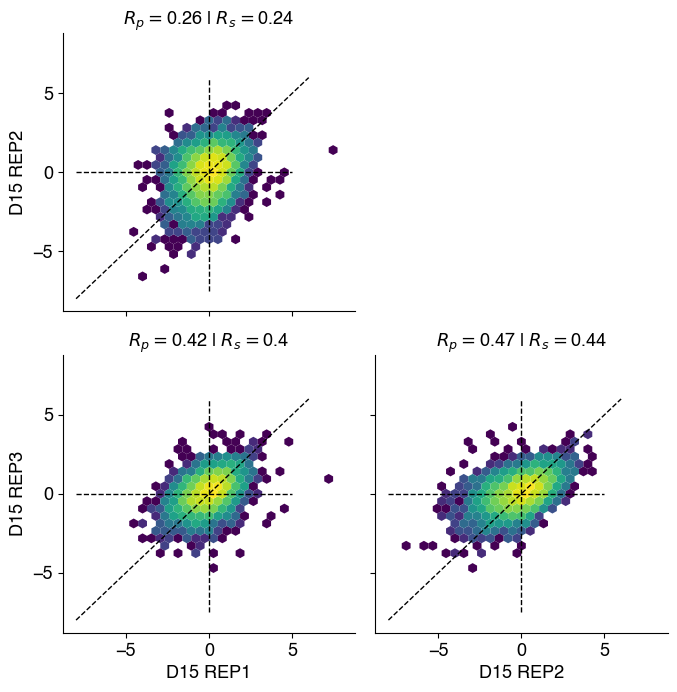

In [ ]:
COI = 'd15'
min_edit = 50
samples = list(CBE_samp_dict2[COI])

s2 = samples +  ['classification', 'target_base_edit_perc']
KO = CBE_LFC[s2]

KO = KO[KO['target_base_edit_perc']>= min_edit]

fig, ax = plt.subplots(len(samples),len(samples),figsize=(20,20), sharex=True, sharey=True)

palette = ['#F9CBA8', '#ED6A50', '#7284A1', 'lightgrey', 'darkslategray']


s_dict = {'LFC_d15': 'LFC In Vitro', 'LFC_spleen': 'LFC Spleen', 'LFC_bone': 'LFC Bone', 'LFC_meninges': 'LFC Meninges'}
for idx, samp in enumerate(samples):

    row = idx
    for idx2, samp2 in enumerate(samples):
        col = idx2
        ax[row][col].hexbin(KO[samp2], KO[samp], bins='log', gridsize=30, linewidth=0, extent = (-8, 8, -8, 8))

        ax[row][col].plot([0,0],[-7.5,6], linestyle='dashed', color='black', linewidth=1)
        ax[row][col].plot([-8,5],[0,0], linestyle='dashed', color='black', linewidth=1)
        ax[row][col].plot([-8,6],[-8,6], linestyle='dashed', color='black', linewidth=1)


        if samp[-2:]=='10':
            j1 = f'{samp[:-2].upper()} {samp[-2:]}'
        elif '_' in samp:
            j1 = samp.split('_')[0].upper() + ' ' + samp.split('_')[1].upper()
        else:
            j1 = f'{samp[:-1].upper()} {samp[-1:]}'

        if samp2[-2:]=='10':
            j2 = f'{samp2[:-2].upper()} {samp2[-2:]}'
        elif '_' in samp2:
            j2 = samp2.split('_')[0].upper() + ' ' + samp2.split('_')[1].upper()
        else:
            j2 = f'{samp2[:-1].upper()} {samp2[-1:]}'


        ax[row][0].set_ylabel(j1, fontsize=13)
        ax[len(samples)-1][col].set_xlabel(j2, fontsize=13)
    #ax[idx//3][idx%3].set_xticklabels(['S', 'B', 'M'])
    #ax[idx//3][idx%3].set_yticklabels(['IV', 'S', 'B',])
    #ax[idx//3][idx%3].set_title(f'{gene}', fontsize=12)

        ax[row][col].spines[['top', 'right']].set_visible(False)

        ax[row][col].tick_params(axis='both', which='major', labelsize=13,)

        spear = np.round(scipy.stats.spearmanr(KO[samp2], KO[samp]).statistic, 2)
        pear = np.round(scipy.stats.pearsonr(KO[samp2], KO[samp]).statistic, 2)

        ax[row][col].set_title('$R_{p} = $' + f'{pear}' + ' | $R_{s} = $' + f'{spear}', fontsize=13)


        if row<=col:
            fig.delaxes(ax[row][col])

fig.tight_layout()
#fig.savefig(f'figures/CBE_supp_pairwise_comp_{COI}.pdf', transparent=True)